# Preparing
Run once when disconnected

In [85]:
# imports
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import zipfile
from sklearn.metrics import f1_score
import os
from google.colab import files
import matplotlib.pyplot as plt

In [20]:
# download the dataset
if (not os.path.isfile('x.npy')):
    !wget -q https://gist.github.com/kezzyhko/74136f15acb0ac57e64a761176776ab0/raw/x.npy
if (not os.path.isfile('y.npy')):
    !wget -q https://gist.github.com/kezzyhko/74136f15acb0ac57e64a761176776ab0/raw/y.npy

In [21]:
# load the dataset

x = np.load('x.npy')
y = np.load('y.npy')

print(x.shape)
print(y.shape)

(50000, 28, 28, 1)
(50000,)


In [22]:
# load mnist (for evaluation later)
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()
mnist_X_train = mnist_X_train.reshape((60000, 28, 28, 1))
mnist_X_test = mnist_X_test.reshape((10000, 28, 28, 1))
print(mnist_X_train.shape)
print(mnist_y_train.shape)
print(mnist_X_test.shape)
print(mnist_y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


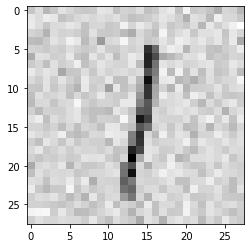

In [120]:
# DOESN'T change the dataset, just for test and visualisation

# plt.imshow(x[0].reshape(28, 28)/255., cmap='Greys')
g = GaussianNoise(30)
x_g = g(x.reshape(50000, 28, 28).astype('float32'), training=True)
plt.imshow(x_g[0]/255., cmap='Greys')

# Data augmentation

In [23]:
generator = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.3,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    validation_split = 0.15
)

# The model

## Make the model

In [130]:
# create the model

model = Sequential()

model.add(GaussianNoise(30, input_shape=(28, 28, 1)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2, padding='same'))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2, padding='same'))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2, padding='same'))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2, padding='same'))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2, padding='same'))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Recall(), Precision()])

In [131]:
# train the model
# model.fit(x, pd.get_dummies(y).astype(np.float32), validation_split=0.15)
model.fit(
    generator.flow(x, pd.get_dummies(y).astype(np.float32)),
    validation_data = generator.flow(x, pd.get_dummies(y).astype(np.float32), subset = 'validation'),
)

1563/1563 [==============================] - 1781s 1s/step - loss: 0.5120 - recall_9: 0.8046 - precision_9: 0.9307 - val_loss: 0.1647 - val_recall_9: 0.9365 - val_precision_9: 0.9695


## Save the model

In [132]:
# save the model
model.save('model.h5')
zipfile.ZipFile('model.h5.zip', mode='w').write("model.h5")
files.download('model.h5.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate on itself

In [133]:
# make the prediction
y_pred = model.predict(x)
# transform prediction to labels
y_pred_labels = np.argmax(y_pred, axis=1).astype(np.uint8)

In [134]:
# evaluate performance of the model
tf.print(f1_score(y_pred_labels, y, average='micro'))
tf.print(f1_score(y_pred_labels, y, average='macro'))
tf.print(f1_score(y_pred_labels, y, average='weighted'))

0.9692
0.9692537976083395
0.9691705890962193


## Evaluate on mnist test

In [135]:
# predict on mnist test
y_pred_mnist_test = np.argmax(model.predict(mnist_X_test), axis=1).astype(np.uint8)

In [136]:
# evaluate on mnist test
tf.print(f1_score(y_pred_mnist_test, mnist_y_test, average='micro'))
tf.print(f1_score(y_pred_mnist_test, mnist_y_test, average='macro'))
tf.print(f1_score(y_pred_mnist_test, mnist_y_test, average='weighted'))

0.9709
0.9709657726427032
0.9709083334647728


# Evaluate on mnist train

In [137]:
# predict on mnist train
y_pred_mnist_train = np.argmax(model.predict(mnist_X_train), axis=1).astype(np.uint8)

In [138]:
# evaluate on mnist train
tf.print(f1_score(y_pred_mnist_train, mnist_y_train, average='micro'))
tf.print(f1_score(y_pred_mnist_train, mnist_y_train, average='macro'))
tf.print(f1_score(y_pred_mnist_train, mnist_y_train, average='weighted'))

0.9691166666666666
0.9691694024934652
0.9690951255230696
